# Load the data

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp

# from scipy.special import erfinv
from scipy.stats import norm

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

%matplotlib inline

import matplotlib.pyplot as plt

In [56]:
data_train_raw = pd.read_csv('../input/train.csv')
# data_train_raw = data_train_raw.sample(frac=0.01, random_state=0)
data_test_raw = pd.read_csv('../input/test.csv')

In [57]:
data_train_raw.shape

(188318, 132)

# Data transformation

In [58]:
ylog=np.log1p(data_train_raw['loss'])
ymean=ylog.mean()
ystd=ylog.std()
# ymean=0
# ystd=1
data_train_raw['loss_g']=(ylog-ymean)/ystd

In [59]:
# clean outliers in training data
lossMean = data_train_raw['loss_g'].mean()
lossStd = data_train_raw['loss_g'].std()
print('Mean of log1py: {}'.format(lossMean))
print('Std of log1py: {}'.format(lossStd))
lbound = lossMean-3.0*lossStd
ubound = lossMean+3.0*lossStd
print('Lower clipping bound: {}\nUpper clipping bound: {}'.format(lbound, ubound))
data_train_raw = data_train_raw[(data_train_raw['loss_g']>=lbound) & (data_train_raw['loss_g']<=ubound)]
print('Shape of cleaned data: {}'.format(data_train_raw.shape))

Mean of log1py: -1.13349409935e-13
Std of log1py: 1.0
Lower clipping bound: -3.0
Upper clipping bound: 3.0
Shape of cleaned data: (187954, 133)


In [60]:
def ToUniform(y):
    z = norm.cdf(-y/np.sqrt(2))
    return z
def UniformToGauss(z):
    return -np.sqrt(2)*norm.ppf(z)*ystd+ymean
# def BackToOriginal(z):
#     return np.exp(UniformToGauss(z))

data_train_raw['loss_u']=ToUniform(data_train_raw['loss_g'])

def lossRestore(logloss, ymean, ystd):
    loss = np.expm1(logloss*ystd+ymean)
    return loss

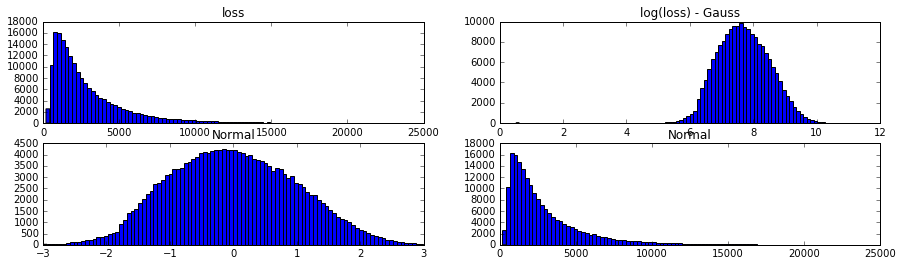

In [61]:
plt.figure(figsize=(15,4))

plt.subplot(2,2,1)
plt.hist(data_train_raw['loss'],100)
plt.title('loss');

plt.subplot(2,2,2)
plt.hist(ylog,100)
plt.title('log(loss) - Gauss');

plt.subplot(2,2,3)
plt.hist(data_train_raw['loss_g'],100)
plt.title('Normal');

plt.subplot(2,2,4)
plt.hist(lossRestore(data_train_raw['loss_g'],ymean,ystd),100)
plt.title('Normal');

# Data preparation - labeling encoder

In [62]:
# save label in a seperate serie
labelSs = data_train_raw['loss_g'] 
trainDf = data_train_raw.drop(['id','loss','loss_g','loss_u'],axis=1)
subId = data_test_raw['id']
testDf = data_test_raw.drop(['id'],axis=1)

print('trainDf has features from the raw data:\n{}'.format(trainDf.columns))
print('testDf has features from the raw data:\n{}'.format(testDf.columns))

trainDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)
testDf has features from the raw data:
Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cont5', u'cont6', u'cont7', u'cont8', u'cont9', u'cont10', u'cont11',
       u'cont12', u'cont13', u'cont14'],
      dtype='object', length=130)


In [63]:
dataAll = pd.concat([trainDf,testDf])
dataCatAll = dataAll.select_dtypes(include=['object'])
dataFltAll = dataAll.select_dtypes(include=['float64'])
print('the stacked data\'s dimension are:\n{}'.format(dataAll.shape))
print('{} of which are categorical'.format(dataCatAll.shape))
print('{} of which are continuous'.format(dataFltAll.shape))

the stacked data's dimension are:
(313500, 130)
(313500, 116) of which are categorical
(313500, 14) of which are continuous


In [64]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for col in dataCatAll.columns:
    if (col.find('cat') !=-1):
#        print(col)
        dataCatAll[col]=le.fit_transform(dataCatAll[col])
#         dataAll[col] = dataAll[col].map(lambda s: '<unknown>' if s not in le.classes_ else s)
#         le.classes_ = np.append(le.classes_, '<unknown>')
#         data_test_raw[str(col+'_numerical')]=le.transform(data_test_raw[col])
print(dataCatAll.columns)


/home/ec2-user/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Index([u'cat1', u'cat2', u'cat3', u'cat4', u'cat5', u'cat6', u'cat7', u'cat8',
       u'cat9', u'cat10',
       ...
       u'cat107', u'cat108', u'cat109', u'cat110', u'cat111', u'cat112',
       u'cat113', u'cat114', u'cat115', u'cat116'],
      dtype='object', length=116)


# restore to x_trainDf and x_testDf - skipped

In [65]:
# # hstack all the features and .
# x_allDf = pd.concat([dataCatAll,dataFltAll],axis=1)
# x_means = x_allDf.mean()
# x_stds = x_allDf.std()
# x_allDf = (x_allDf-x_means)/x_stds
# x_allDf.head()

In [66]:
# x_Train = x_allDf.iloc[0:len(labelSs),:]
# x_Test = x_allDf.iloc[len(labelSs):,:]
# y_Train = labelSs

# one-hot-encoding

In [67]:
# one-hot-encoding the categorical features
enc = preprocessing.OneHotEncoder()
x_catAll = enc.fit_transform(dataCatAll)
print(x_catAll.shape)

(313500, 1175)


In [68]:
# split x_train and x_test
x_Train = sp.sparse.hstack((x_catAll[0:len(labelSs),:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[0:len(labelSs),:]))
x_Test = sp.sparse.hstack((x_catAll[len(labelSs):,:], sp.sparse.csr_matrix(dataFltAll.as_matrix())[len(labelSs):,:]))
y_Train = labelSs.values

# check the dimension of prepared data

In [69]:
print(x_Test.shape)
print(x_Train.shape)
print(y_Train.shape)

(125546, 1189)
(187954, 1189)
(187954,)


# splite the training data for valication

In [70]:
from sklearn import cross_validation
val_size = 0.2
seed = 0
x_train, x_val, y_train, y_val = cross_validation.train_test_split(x_Train, y_Train, test_size=val_size, random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(150363, 1189)
(150363,)
(37591, 1189)
(37591,)


In [71]:
del x_Train
del y_Train
del x_catAll
del dataCatAll
# del trainDf
# del testDf

# Model Fitting

In [72]:
from sklearn.metrics import mean_absolute_error
y_pred = []
y_pred_val = []
submission = pd.read_csv('../input/sample_submission.csv')

In [252]:
testList = ['Ridge', 'XGBoostTrees', 'AdaBoosting', 'MLPRegressor','Ensemble']

### Ridge Regression

In [73]:
from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import Ridge

In [74]:
cv = 3
# alphas = (1e-2,1e-1,1,1e1,1e2)
# alphas = (20,30,40)
alphas = [40]
regCV = RidgeCV(cv=cv,alphas = alphas)
regCV.fit(x_train,y_train)
print('alpha: {}\n'.format(regCV.alpha_))
# print('cv_values_: {}\n'.format(regCV.cv_values_))

alpha: 40



In [75]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(regCV.predict(x_val),ymean,ystd)))

1229.03505606


In [76]:
y_pred_i = lossRestore(regCV.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(regCV.predict(x_val),ymean,ystd))

### Lasso Regression

In [77]:
# from sklearn.linear_model import LassoCV

In [78]:
# cv = 3
# # alphas = (1e-3,1e-2,1e-1,1,1e1,1e2,1e3)
# # alphas = (0.0005,0.0007,0.001,0.003,0.005)
# # alphas = [0.00005,0.0001,0.0003,0.0005]
# alphas = [0.00005]
# LassoCV = LassoCV(cv=cv,alphas = alphas)
# LassoCV.fit(x_train,y_train)
# print('alpha: {}\n'.format(LassoCV.alpha_))

In [79]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(LassoCV.predict(x_val),ymean,ystd)))

In [80]:
# y_pred_i = lossRestore(LassoCV.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(LassoCV.predict(x_val),ymean,ystd))

### Skipped - Random Forest - using mse rather than mae, because the mae implementation is much slower.

In [81]:
# from sklearn.ensemble import RandomForestRegressor

In [82]:
# criterion = 'mse'
# n_estimators = [30]
# err = 999999999
# n_estimator = 0
# random_state = 0
# for n_est in n_estimators:
#     tmpRFReg = RandomForestRegressor(n_estimators = n_est,criterion = criterion, random_state = random_state)
#     tmpRFReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpRFReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         RFReg = tmpRFReg
#         n_estimator = n_est
#         err = err_i

In [83]:
# print('n_estimator = {}'.format(n_estimator))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(RFReg.predict(x_val),ymean,ystd)))

In [84]:
# y_pred_i = lossRestore(RFReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(RFReg.predict(x_val),ymean,ystd))

### XGBoost Trees

In [85]:
import xgboost as xgb

In [86]:
d_train_xgb = xgb.DMatrix(x_train.tocsc(),label=y_train)
d_val_xgb = xgb.DMatrix(x_val.tocsc(),label = y_val)
x_val_xgb = xgb.DMatrix(x_val.tocsc())
d_test_xgb = xgb.DMatrix(x_Test.tocsc())

In [227]:
num_round = 700
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.155,'min_child_weight':1}# 1134, 200 rounds
# params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.15,'min_child_weight':1}# 1133, 250 rounds
params = {'eval_metric':'mae','max_depth':6,'colsample_bytree':1,'alpha':1,'gamma':1,'eta':0.1,'min_child_weight':1}# 1131, 700 rounds
watchlist  = [(d_val_xgb,'eval'), (d_train_xgb,'train')]
gbt = xgb.train(params, d_train_xgb,num_round,watchlist)

[0]	eval-mae:0.858036	train-mae:0.860953
[1]	eval-mae:0.816229	train-mae:0.818634
[2]	eval-mae:0.780731	train-mae:0.782676
[3]	eval-mae:0.750834	train-mae:0.752338
[4]	eval-mae:0.724744	train-mae:0.72552
[5]	eval-mae:0.703291	train-mae:0.70364
[6]	eval-mae:0.684084	train-mae:0.684007
[7]	eval-mae:0.667684	train-mae:0.667135
[8]	eval-mae:0.653741	train-mae:0.652827
[9]	eval-mae:0.640905	train-mae:0.639673
[10]	eval-mae:0.630606	train-mae:0.629035
[11]	eval-mae:0.621808	train-mae:0.619868
[12]	eval-mae:0.613286	train-mae:0.611027
[13]	eval-mae:0.606222	train-mae:0.603766
[14]	eval-mae:0.600056	train-mae:0.597361
[15]	eval-mae:0.594882	train-mae:0.591895
[16]	eval-mae:0.589638	train-mae:0.586623
[17]	eval-mae:0.58494	train-mae:0.581553
[18]	eval-mae:0.581038	train-mae:0.577466
[19]	eval-mae:0.577652	train-mae:0.573851
[20]	eval-mae:0.57411	train-mae:0.570296
[21]	eval-mae:0.570354	train-mae:0.566406
[22]	eval-mae:0.567531	train-mae:0.563439
[23]	eval-mae:0.5641	train-mae:0.560054
[24]	eva

In [229]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(gbt.predict(x_val_xgb),ymean,ystd)))

1131.59860287


In [230]:
y_pred_i = lossRestore(gbt.predict(d_test_xgb),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(gbt.predict(x_val_xgb),ymean,ystd))

### AdaBoost Regression

In [231]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Ridge

In [232]:
# n_estimators = [30, 60, 90, 120]
# n_estimators = [10,20,30,40]
n_estimators = [6]
base_estimator = Ridge(alpha = 40)
err = 999999999
n_estimator = 0
random_state = 0
for n_est in n_estimators:
    tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state,base_estimator = base_estimator)
#     tmpAdReg = AdaBoostRegressor(n_estimators = n_est, random_state = random_state)
    tmpAdReg.fit(x_train,y_train)
    err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpAdReg.predict(x_val),ymean,ystd))
    print(err_i)
    if err_i < err:
        AdReg = tmpAdReg
        n_estimator = n_est
        err = err_i

1230.15703558


In [233]:
print('n_estimator = {}'.format(n_estimator))
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(AdReg.predict(x_val),ymean,ystd)))

n_estimator = 6
1230.15703558


In [234]:
y_pred_i = lossRestore(AdReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(AdReg.predict(x_val),ymean,ystd))

### Skipped - K Nearest Neighbors

In [235]:
# from sklearn.neighbors import KNeighborsRegressor

In [236]:
# n_neighbors = [5, 10, 15]
# weights = 'distance'
# err = 999999999
# n_nns = 0
# # random_state = 0
# for n_nn in n_neighbors:
#     tmpKNReg = KNeighborsRegressor(n_neighbors = n_nn,weights = weights)
#     tmpKNReg.fit(x_train,y_train)
#     err_i = mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(tmpKNReg.predict(x_val),ymean,ystd))
#     print(err_i)
#     if err_i < err:
#         KNReg = tmpKNReg
#         n_nns = n_nn
#         err = err_i

In [237]:
# print('n_neighbors = {}'.format(n_nns))
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(KNReg.predict(x_val),ymean,ystd)))

In [238]:
# y_pred_i = lossRestore(KNReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(KNReg.predict(x_val),ymean,ystd))

### Linear SVR

In [239]:
# from sklearn.svm import LinearSVR

In [240]:
# # SVReg = svm.SVR(kernel = 'rbf')
# # SVReg.fit(x_train,y_train)
# SVReg = LinearSVR(C=0.5)
# SVReg.fit(x_train,y_train)

In [241]:
# print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(SVReg.predict(x_val),ymean,ystd)))

In [242]:
# y_pred_i = lossRestore(SVReg.predict(x_Test),ymean,ystd)
# y_pred.append(y_pred_i)
# y_pred_val.append(lossRestore(SVReg.predict(x_val),ymean,ystd))

### MLP Regressor

In [243]:
from sklearn.neural_network import MLPRegressor

In [244]:
MLPReg = MLPRegressor(alpha = 1e-5, hidden_layer_sizes = (35,3),random_state=0,early_stopping=True)
MLPReg.fit(x_train,y_train)

MLPRegressor(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(35, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [245]:
print(mean_absolute_error(lossRestore(y_val,ymean,ystd),lossRestore(MLPReg.predict(x_val),ymean,ystd)))

1150.14015193


In [246]:
y_pred_i = lossRestore(MLPReg.predict(x_Test),ymean,ystd)
y_pred.append(y_pred_i)
y_pred_val.append(lossRestore(MLPReg.predict(x_val),ymean,ystd))

# save files for submission

In [247]:
# ensemble the results
y_pred.append(np.ndarray.mean(np.vstack(y_pred).T,axis=1))

# ensembled y_val
print('The loss of the ensembled result:')
y_pred_val_en = np.ndarray.mean(np.vstack(y_pred_val).T,axis=1)
mean_absolute_error(lossRestore(y_val,ymean,ystd),y_pred_val_en)

The loss of the ensembled result:


1155.9604489843846

In [248]:
# Save all the predictions for submission
for i,stri in enumerate(testList):
    submission['id'] = subId
    submission['loss']=pd.Series(data=y_pred[i])
    submission.to_csv('../output/'+stri+'.csv',index=False)

In [250]:
from sklearn.externals import joblib
joblib.dump([regCV, gbt, AdReg, MLPReg, y_pred, y_pred_val, x_train, x_val, y_train, y_val, x_Test]
            ,'../output/models_data_on_raw_features.pkl',compress=3) 

# clf = joblib.load('filename.pkl') 

['../output/models_data_on_raw_features.pkl']

In [251]:
testList


['RidgeXGBoostTrees', 'AdaBoosting', 'MLPRegressor', 'Ensemble']